#Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shutil import move
from os import listdir, makedirs
from os.path import isfile, join, exists
import torchvision
from tqdm import tqdm
from torchvision import transforms
import os
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch
import shutil
import torchvision.models as models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

# Подгружаю данные напрямую с kaggle, все пипы пусть будут на всякий

In [2]:
#! pip install kaggle

In [3]:
#! mkdir ~/.kaggle

In [4]:
#! cp kaggle.json ~/.kaggle/

In [5]:
#! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#! kaggle competitions download -c study-competition-2-dl-2024

In [7]:
#!unzip study-competition-2-dl-2024.zip

#1) Поизучать данные, подготовить хороший даталоадер & 2) Подготовить аугментацию данных
## Такс, при в этой части ориентировался на тетрадки seminar04 & seminar05 и вот эту вот [штукенцию](https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/), в которой описана часть с image transformations, также в ней узнал много всего интересного о предобученных моделях pytorch

Вот с этой задачкой я провозился довольно долго. Структура data следующая: есть общая папка data, в которой лежат папки train и test. В train лежат классифицрованные папки с набором изображений, чего не скажешь о test, где в рандомном порядке накиданы картиночки для предсказаний. Обращаясь image folder'ом к папке test через root 'data/test' я получаю ошибку, потому что **внутри** папки test просто лежат .jpg, а если пытаться обратитсья к test через root 'data' то image folder засасывает еще и картинки с train. Чтобы решить эту проблему, я создаю внутри папки test подпапку fold, в которую кладу все изображения.

In [8]:
source_directory = 'data/test'

In [9]:
new_folder = os.path.join(source_directory, 'fold')

In [10]:
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

In [11]:
for file_name in os.listdir(source_directory):
    source_file = os.path.join(source_directory, file_name)
    if os.path.isfile(source_file):
        shutil.move(source_file, new_folder)

Перехожу к аугментации, которая является важной частью обучения модели
# **Важный момент**: - если данные уже лежат в нормальном виде (картинки в папках, к которым можно передать root  с явным указанием папки, в которой они лежат), то нужно просто закоментить все строчки до этого момента после импорта библиотек и указать свой путь к папкам

In [12]:
train_dir = 'data/train'
test_dir = 'data/test'

In [13]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # случайное отображение по горизонтали с p =0.5
    transforms.RandomVerticalFlip(), # случайное отображение по вертикали с p=0.5
    transforms.RandomRotation(10), # случайне вращение на угол до +- 10 градусов
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)), # случайное обрезание части изображения, а затем изменение размера полученного фрагмента до 224x224 пикселей
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # случайне изменение яркости, контраста, насыщенности и оттенка изображения
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # случайное примененение перспективного искажения к изображению с коэффициентом искажения 0.2 и p = 0.5
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # применение гауссовского размытия, не знаю, насколько это полезно, но в интернетах писали, что это помогает снижать влияние текстурных деталей и шума на процесс обучения, способствуя обобщению
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # нормализация тензора изображения
])
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # почему 224x224 а не к примеру 256x256? прочитал в интернетах, что resnet и mobile_net любят изображения 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Почему-то использование готового image folder'а плохо работает при попытке извлечения предиктов, поэтому сделал что-то типо костыля с написанием собственногоручного Folder'а (привет 1 домашка)

In [14]:
class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, path

In [15]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = CustomDataset(test_dir, transform=val_test_transforms)

Проверяю, что лежит в test и train

In [16]:
test_data

Dataset CustomDataset
    Number of datapoints: 3000
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:
train_data

Dataset ImageFolder
    Number of datapoints: 18000
    Root location: data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               RandomPerspective(p=0.5)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Отрезаю 10 процентов на валидацию, можно и больше, но не хочется забираться лишние картиночки из обучения

In [18]:
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

Кладу все в DataLoader'ы, батчи по 32 картинки довольно хороший вариант, на гпу обработка одного батчка занимает 2.5 секунды, а аккураси стремится к единице. В train указываю shuffle = True

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
train_loader

Копипаст кода с семинаров для отрисовки картинок в батче

In [21]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [22]:
def show_images(data_loader):
    try:
        inputs, classes = next(iter(data_loader))
    except NameError:
        print("DataLoader не определен")
        return
    out = torchvision.utils.make_grid(inputs, nrow=8)  # В батче 32 картинки, в одной строке будет 8 картинок
    try:
        class_names = data_loader.dataset.classes
        titles = [class_names[x] for x in classes]
    except AttributeError:
        titles = ["Class: {}".format(x) for x in classes]  # Дополнительно вывожу номер класса для картиночки
    imshow(out, title=", ".join(titles))

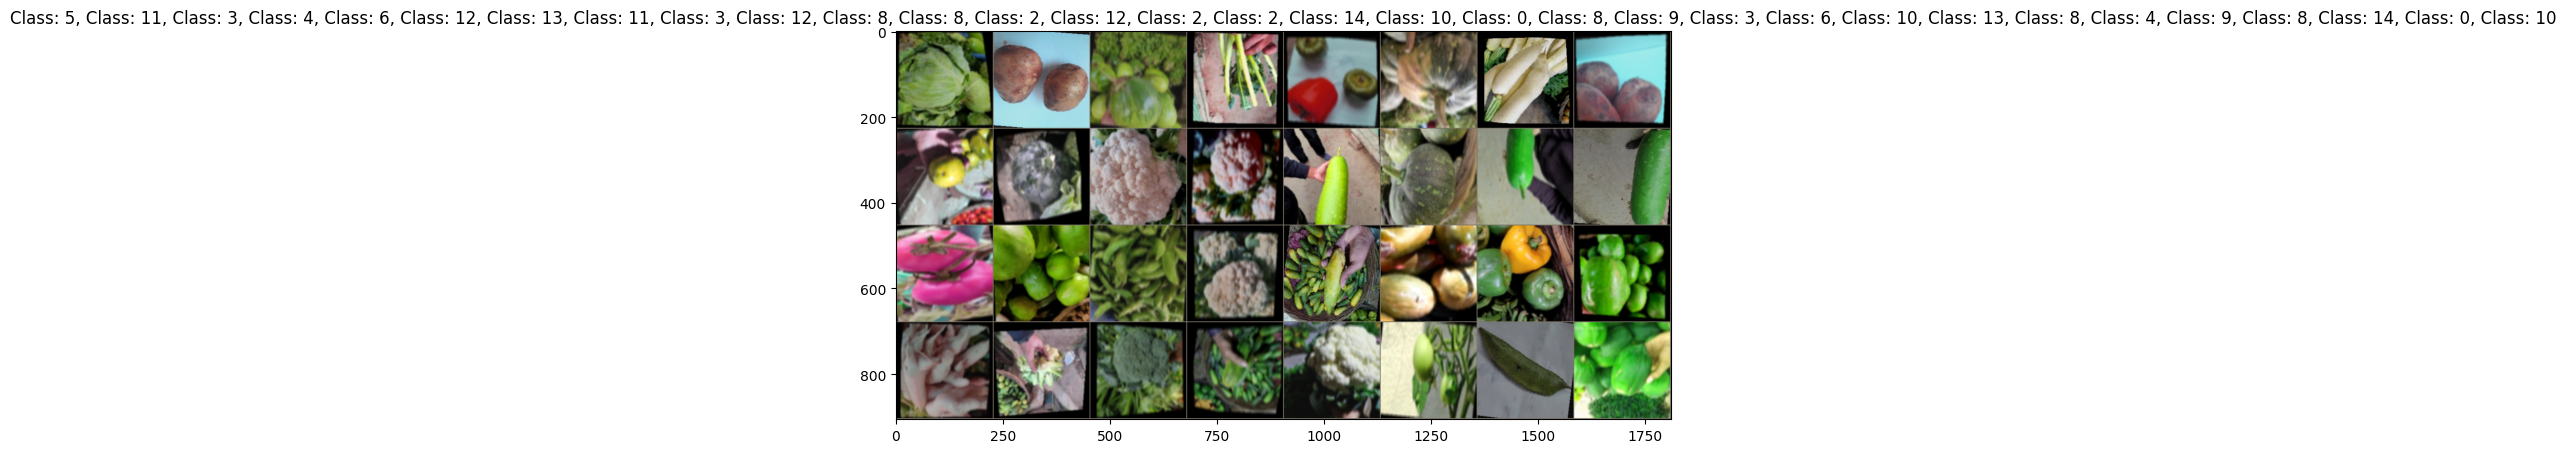

In [23]:
show_images(train_loader)

# 3) Использовать transfer learning (как с файнтюнингом, так и без), можно сделать свою нейронную сеть, если она будет лучше transfer learning (но нужно показать это на валидации)

Писать свою сетку я точно не хочу, поэтому буду использовать предобученную и сделаю файнтюнинг на наших данных. Посмотрим, что за модели есть в pytorch

In [24]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

Из всех представленных моделей меня заинтеросовали 2:
resnet_n_Weights (n = 50 или 152) и mobilenet_v3, поэтому буду использовать их

Определяю resnet50

In [25]:
#model = models.resnet50(pretrained=True)

Определяю resnet152

In [26]:
#model = models.resnet152(pretrained=True)

Определяю mobilenet_v3

In [27]:
model = models.mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Посмотрим какие параметры имеет модель, по большей степени меня интересует последний слой. В resnet он называется fc, а в mobile_net classifier

In [28]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Изменяю последний слой для файнтюнинга модели resnet

In [29]:
#num_ftrs = model.fc.in_features
#num_classes = len(train_data.classes)
#model.fc = nn.Linear(num_ftrs, num_classes)

Изменяю последний слой для файнтюнинга модели mobile_net

In [30]:
num_ftrs = model.classifier[3].in_features
num_classes = len(train_data.classes)
model.classifier[3] = nn.Linear(num_ftrs, num_classes)

Количество выходных классов, которые будет выдавать модель

In [31]:
num_classes

15

Последний слой для resnet

In [32]:
#model.fc

Последний слой для mobile_net

In [33]:
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=15, bias=True)
)

Перекидываю модель на gpu, если она есть

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Функция для обучения сетки, в этот раз решил использовать валидационную выборку для более качественных результатов, с помощью шедулера буду варировать скорость обучения, целевая метрика - аккураси

In [35]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Здесь храню лоссы и аккураси
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss, train_corrects = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Train'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        # Валидация
        model.eval()
        val_loss, val_corrects = 0, 0
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validate'):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        # Сохранение результатов
        train_losses.append(train_loss / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))
        train_accs.append(train_corrects.double().item() / len(train_loader.dataset))
        val_accs.append(val_corrects.double().item() / len(val_loader.dataset))

        # Вывод лосса и аккураси на трейне и валидации
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

        # С помощью шедулера управляю скоростью обучения, ориентируюсь на лосс на валидции
        scheduler.step(val_losses[-1])

    # Визуализация
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Лосс во время тренировки')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Аккураси во время тренировки')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model


In [36]:
criterion = torch.nn.CrossEntropyLoss() # в задачах классификации использую кросс-энтропию, в регрессии MSEloss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # оптимайзер взял стозастический градиентный бустинг, он показал хорошие результаты, в отличие от adam
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # шедулер

Запускаю модель на обучение

Epoch 1/15 - Validate: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15 - Train Loss: 0.6279, Train Acc: 0.8641, Val Loss: 0.1120, Val Acc: 0.9761


Epoch 2/15 - Validate: 100%|██████████| 57/57 [00:38<00:00,  1.48it/s]


Epoch 2/15 - Train Loss: 0.0992, Train Acc: 0.9770, Val Loss: 0.0480, Val Acc: 0.9883


Epoch 3/15 - Validate: 100%|██████████| 57/57 [00:36<00:00,  1.54it/s]


Epoch 3/15 - Train Loss: 0.0605, Train Acc: 0.9845, Val Loss: 0.0271, Val Acc: 0.9961


Epoch 4/15 - Validate: 100%|██████████| 57/57 [00:37<00:00,  1.51it/s]


Epoch 4/15 - Train Loss: 0.0403, Train Acc: 0.9899, Val Loss: 0.0235, Val Acc: 0.9944


Epoch 5/15 - Validate: 100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


Epoch 5/15 - Train Loss: 0.0304, Train Acc: 0.9927, Val Loss: 0.0156, Val Acc: 0.9967


Epoch 6/15 - Validate: 100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


Epoch 6/15 - Train Loss: 0.0245, Train Acc: 0.9944, Val Loss: 0.0147, Val Acc: 0.9939


Epoch 7/15 - Validate: 100%|██████████| 57/57 [00:38<00:00,  1.50it/s]


Epoch 7/15 - Train Loss: 0.0242, Train Acc: 0.9944, Val Loss: 0.0121, Val Acc: 0.9967


Epoch 8/15 - Validate: 100%|██████████| 57/57 [00:41<00:00,  1.39it/s]


Epoch 8/15 - Train Loss: 0.0177, Train Acc: 0.9961, Val Loss: 0.0101, Val Acc: 0.9972


Epoch 9/15 - Validate: 100%|██████████| 57/57 [00:38<00:00,  1.48it/s]


Epoch 9/15 - Train Loss: 0.0167, Train Acc: 0.9958, Val Loss: 0.0082, Val Acc: 0.9983


Epoch 10/15 - Validate: 100%|██████████| 57/57 [00:37<00:00,  1.51it/s]


Epoch 10/15 - Train Loss: 0.0167, Train Acc: 0.9952, Val Loss: 0.0061, Val Acc: 0.9994


Epoch 11/15 - Validate: 100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


Epoch 11/15 - Train Loss: 0.0121, Train Acc: 0.9973, Val Loss: 0.0078, Val Acc: 0.9978


Epoch 12/15 - Validate: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Epoch 12/15 - Train Loss: 0.0112, Train Acc: 0.9971, Val Loss: 0.0096, Val Acc: 0.9967


Epoch 13/15 - Validate: 100%|██████████| 57/57 [00:38<00:00,  1.47it/s]


Epoch 13/15 - Train Loss: 0.0107, Train Acc: 0.9974, Val Loss: 0.0069, Val Acc: 0.9983


Epoch 14/15 - Validate: 100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


Epoch 14/15 - Train Loss: 0.0100, Train Acc: 0.9975, Val Loss: 0.0058, Val Acc: 0.9989


Epoch 15/15 - Validate: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]


Epoch 15/15 - Train Loss: 0.0097, Train Acc: 0.9975, Val Loss: 0.0060, Val Acc: 0.9983


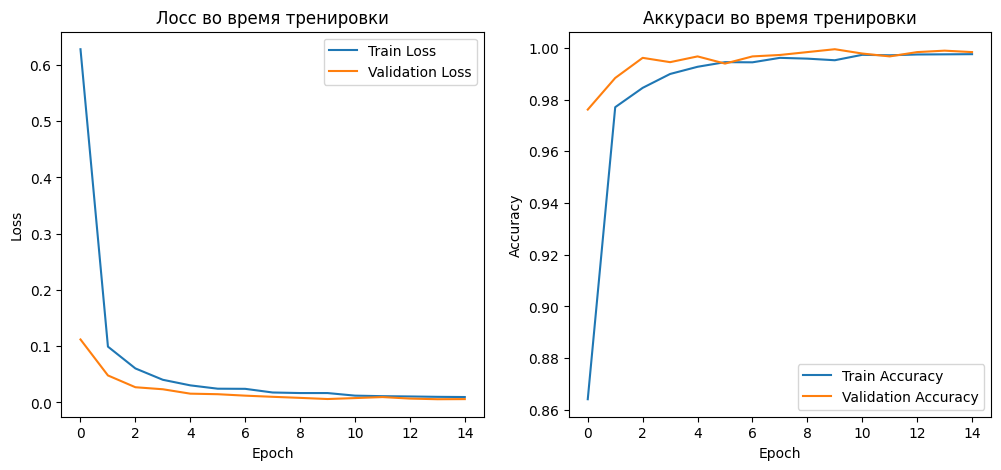

In [37]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs = 15) # можно спокойно ставить 3-5 эпох, проверил: на 15 не становится лучше результат, до этого обучал на 3-5

# Вывожу предикты модели. Из всего этого, я хочу забрать номер картинки и предсказанный класс

In [38]:
trained_model.eval()
predictions = []
for images, paths in test_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = trained_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(zip(predicted.cpu().numpy(), paths))
for pred, img_name in predictions:
    print(f"Image: {img_name.split('/')[-1]}, Predicted class: {pred}")

Image: 0.jpg, Predicted class: 5
Image: 1.jpg, Predicted class: 11
Image: 10.jpg, Predicted class: 0
Image: 100.jpg, Predicted class: 10
Image: 1000.jpg, Predicted class: 2
Image: 1001.jpg, Predicted class: 1
Image: 1002.jpg, Predicted class: 2
Image: 1003.jpg, Predicted class: 8
Image: 1004.jpg, Predicted class: 12
Image: 1005.jpg, Predicted class: 14
Image: 1006.jpg, Predicted class: 10
Image: 1007.jpg, Predicted class: 3
Image: 1008.jpg, Predicted class: 10
Image: 1009.jpg, Predicted class: 3
Image: 101.jpg, Predicted class: 6
Image: 1010.jpg, Predicted class: 7
Image: 1011.jpg, Predicted class: 6
Image: 1012.jpg, Predicted class: 2
Image: 1013.jpg, Predicted class: 7
Image: 1014.jpg, Predicted class: 11
Image: 1015.jpg, Predicted class: 9
Image: 1016.jpg, Predicted class: 6
Image: 1017.jpg, Predicted class: 7
Image: 1018.jpg, Predicted class: 3
Image: 1019.jpg, Predicted class: 5
Image: 102.jpg, Predicted class: 11
Image: 1020.jpg, Predicted class: 7
Image: 1021.jpg, Predicted clas

In [39]:
predictions

[(5, 'data/test/fold/0.jpg'),
 (11, 'data/test/fold/1.jpg'),
 (0, 'data/test/fold/10.jpg'),
 (10, 'data/test/fold/100.jpg'),
 (2, 'data/test/fold/1000.jpg'),
 (1, 'data/test/fold/1001.jpg'),
 (2, 'data/test/fold/1002.jpg'),
 (8, 'data/test/fold/1003.jpg'),
 (12, 'data/test/fold/1004.jpg'),
 (14, 'data/test/fold/1005.jpg'),
 (10, 'data/test/fold/1006.jpg'),
 (3, 'data/test/fold/1007.jpg'),
 (10, 'data/test/fold/1008.jpg'),
 (3, 'data/test/fold/1009.jpg'),
 (6, 'data/test/fold/101.jpg'),
 (7, 'data/test/fold/1010.jpg'),
 (6, 'data/test/fold/1011.jpg'),
 (2, 'data/test/fold/1012.jpg'),
 (7, 'data/test/fold/1013.jpg'),
 (11, 'data/test/fold/1014.jpg'),
 (9, 'data/test/fold/1015.jpg'),
 (6, 'data/test/fold/1016.jpg'),
 (7, 'data/test/fold/1017.jpg'),
 (3, 'data/test/fold/1018.jpg'),
 (5, 'data/test/fold/1019.jpg'),
 (11, 'data/test/fold/102.jpg'),
 (7, 'data/test/fold/1020.jpg'),
 (14, 'data/test/fold/1021.jpg'),
 (11, 'data/test/fold/1022.jpg'),
 (12, 'data/test/fold/1023.jpg'),
 (9, 'data

Создаю датафрейм с предсказанным классом и путем к картинке

In [40]:
df = pd.DataFrame(predictions, columns=['Predicted Class', 'Full Path'])

Режим кринжового кода on

In [41]:
df['Image Name'] = df['Full Path'].apply(lambda x: x.split('/fold/')[1]) # выцепляю номер картинки с .jpg

In [42]:
df['Image Number'] = df['Image Name'].apply(lambda x: int(x.split('.')[0])) # выцепляю номер картинки
df_sorted = df.sort_values(by='Image Number') # сортирую по номерку картинки чтобы сабмишн правильно застакался с test data

Режим кринжового кода off

In [43]:
df_sorted

,Predicted Class,Full Path,Image Name,Image Number
0,5,data/test/fold/0.jpg,0.jpg,0
1,11,data/test/fold/1.jpg,1.jpg,1
1112,4,data/test/fold/2.jpg,2.jpg,2
2223,13,data/test/fold/3.jpg,3.jpg,3
2334,3,data/test/fold/4.jpg,4.jpg,4
...,...,...,...,...
2218,7,data/test/fold/2995.jpg,2995.jpg,2995
2219,13,data/test/fold/2996.jpg,2996.jpg,2996
2220,1,data/test/fold/2997.jpg,2997.jpg,2997
2221,13,data/test/fold/2998.jpg,2998.jpg,2998


Создаю датафрейм для выгрузки в виде сабмишена - отбираю айди и предикты

In [44]:
final_df = df_sorted[['Image Number', 'Predicted Class']].rename(columns={'Image Number': 'id', 'Predicted Class': 'prediction'})
final_df

,id,prediction
0,0,5
1,1,11
1112,2,4
2223,3,13
2334,4,3
...,...,...
2218,2995,7
2219,2996,13
2220,2997,1
2221,2998,13


# Выгружаю предикты

In [45]:
final_df.to_csv('submission_serdyukov.csv', index=False)

По итогу использовал модель мобайл нет, ее accuracy ~ 0.995 - 0.9993
Не стал заморачиваться с аугментацией: была идея найти похожие датасеты на каггле/где-то в интернетах и добавить их в тренировочный набор, либо самому поразмечать картиночки, но результаты работы зафайнтюненой сетки итак очень и очень хорошие, честно говоря, для улучшения скора на десятититысячные доли тратить n-ное количество часов на сбор дополнительных данных несильно хотелось, но если бы такая нужда была, то действовал в таком бы ключе.
По поводу каких-то фишек: в этот раз в отличие от 1 соревновнаия заюзал валидационную выборку, чтобы эффективнее обучать модель, мб потянет на фишку =) и докинул шедулер, чтобы процесс обучения, опять же, был эффективнее. По ощущениям, благодаря довольно большому датасету и качественным картинкам, использовать какие-то супер фишки несильно то и надо, предобученные модели хорошо справляются.